# Домашняя работа "Численное дифференцирование"
## Лехтерев В.В. Б01-204, 2024г.

# Реализация алгоритма
Вычисление производной было реализовано через следующий алгоритм:
1. Дискретизация функции на заданном интервале с заданным шагом $h$
2. Свертка последовательности значений функции с заданным ядром нечетного размера
3. Вычисление отклонения по равномерной метрике

### Комментарий к шагу 2

При дискретизации значения функций преобразуются в последовательность

${f_n} = f(x_n)$.

Рассмотрим формулу

$f'(x) = \frac{f(x+h) - f(x)}{h}$.

При дискретизации она преобразуется в

${f'_n} = {f'(x_n)} = {\frac{f_{n+1} - f_n}{h}} = (\{f_k\} * \frac{[0, -1, 1]}{h})_n$,

где $(\cdot * \cdot)_n$ - дискретная операция [свертки](https://numpy.org/doc/2.0/reference/generated/numpy.convolve.html#r95849f33d2b1-1).

Операция свертки была выбрана потому, что она уже реализована в ***numpy*** и, следовательно, является оптимальной.

### Комментарий к шагу 3

Отклонение вычисленной производной от действительного ее вида высчитывается по равномерной метрике на заданном интервале:

$\Delta = \max\limits_{n} |f'_n - (\frac{df}{dx})(x_n)|$,

где $\frac{df}{dx}$ - заранее известная производная функции $f$.

In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# Kernel should be native list unnormalized to h
def calc_derivative(func, derivative, kernel, bounds, step):
    assert len(kernel) % 2 == 1
    kernel = np.array(kernel, dtype=np.float64)

    X = np.arange(bounds[0], bounds[1], step, dtype=np.float64)
    Y = func(X)
    Yd_true = derivative(X)

    kernel /= step

    Yd = np.convolve(Y, kernel[::-1], 'valid')

    # Clip
    endsize = len(kernel) // 2
    X = X[endsize:-endsize]
    Y = Y[endsize:-endsize]
    Yd_true = Yd_true[endsize:-endsize]

    assert len(Yd) == len(Y)

    return X, Y, Yd, Yd_true

def metric(Yd, Yd_true): 
    err = np.abs(Yd_true - Yd)
    return np.max(err)

def calc_errors(func, derivative, kernel, bounds, step_powers):
    N = np.arange(step_powers[0], step_powers[1] + 1, 1)
    S = np.empty_like(N, dtype=np.float64)
    E = np.empty_like(S)

    for i in range(len(N)):
        S[i] = 2. / 2**N[i]
        _, Y, Yd, Yd_true = calc_derivative(func, derivative, kernel, bounds, S[i])

        E[i] = metric(Yd_true, Yd)

    return np.array(N), np.array(S), np.array(E)

def get_results(func, derivative, bounds, step_powers, labelled_kernels):
    results = []

    for kernel, label in labelled_kernels:
        result = calc_errors(func, derivative, kernel, bounds, step_powers)
        results.append((*result, label))

    return results

# Реализация отрисовки

In [13]:
def plot_derivative(X, Yd, Yd_true, title):
    plt.plot(X, Yd_true, 'k--', label="$True$")
    plt.plot(X, Yd, 'r-', label="$Calculated$")

    plt.title(title)

    plt.legend()
    plt.grid()
    plt.show()

def plot_results(results, title):
    for result in results:
        S = result[1]
        E = result[2]
        label = result[3]

        plt.plot(S, E, label=label)

    plt.title(title)
    plt.xlabel("$h$")
    plt.ylabel("$\Delta$")

    plt.xscale('log', base=2)
    plt.yscale('log', base=2)
    plt.grid()
    plt.legend()
    plt.show()

# Проверка корректности

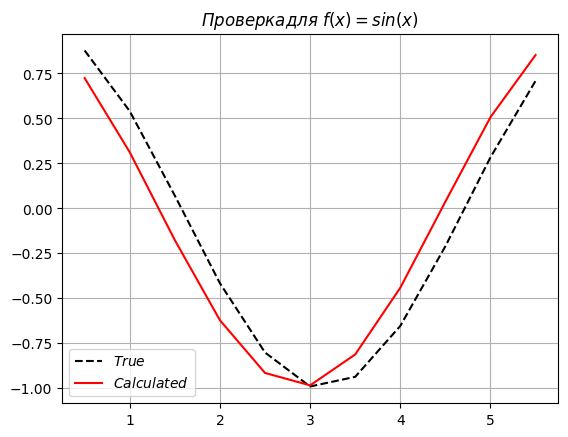

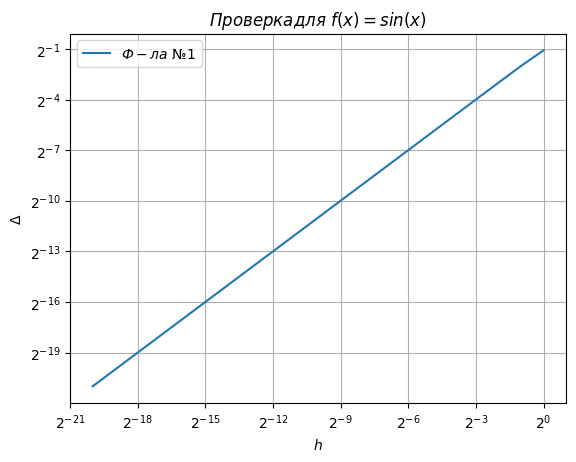

In [14]:
func = np.sin
derivative = np.cos

kernel = [0, -1, 1]
bounds = (0, 2*np.pi)
step = 0.5

X, Y, Yd, Yd_true = calc_derivative(func, derivative, kernel, bounds, step)
plot_derivative(X, Yd, Yd_true, "$Проверка для~ f(x)=sin(x)$")

results = get_results(func, derivative, bounds, (1, 21), [(kernel, "$Ф-ла ~№1$")])
plot_results(results, "$Проверка для~ f(x)=sin(x)$")

# Получение результатов

Для всех заданный функций вычисления проводятся на интервале $[0, 2\pi]$.

In [15]:
kernel3 = [-0.5, 0, 0.5]
kernel4 = [1./12, -2./3, 0, 2./3, -1./12]
kernel5 = [-1./60, 3./20, -3./4, 0, 3./4, -3./20, 1./60]

kernels = [([0, -1, 1], "Формула 1"),
           ([-1, 1, 0], "Формула 2"),
           (kernel3,    "Формула 3"),
           (kernel4,    "Формула 4"),
           (kernel5,    "Формула 5")]

bounds = (0, 2*np.pi)
step_powers = (1, 21)

## Функция №1

$f(x) = sin(x^2)$

$f'(x) = 2x cos(x^2)$

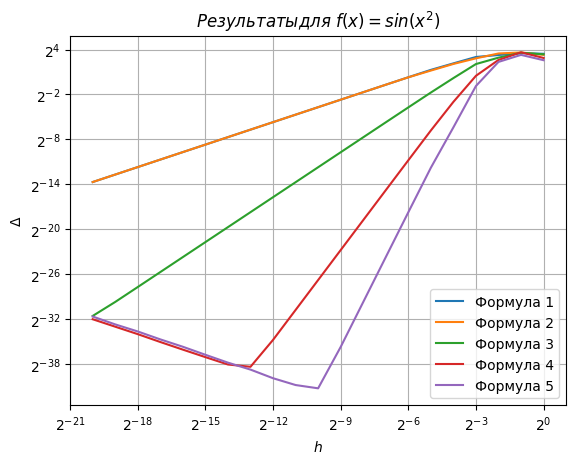

In [16]:
func = lambda X: np.sin(X*X)
derv = lambda X: 2 * X * np.cos(X*X)

results = get_results(func, derv, bounds, step_powers, kernels)
plot_results(results, "$Результаты для~ f(x)=sin(x^2)$")

## Функция №2

$f(x) = cos(sin(x))$

$f'(x) = -cos(x)sin(sin(x))$

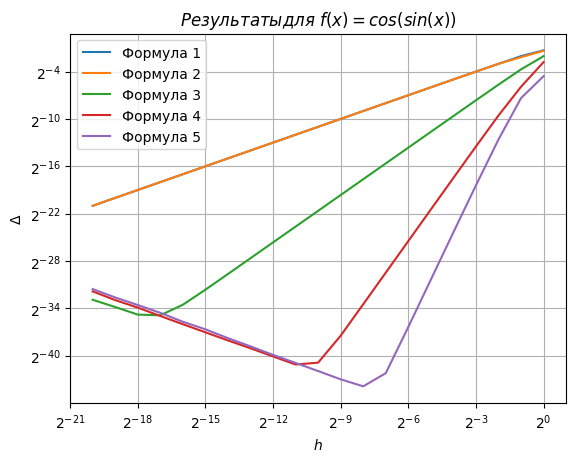

In [17]:
func = lambda X: np.cos(np.sin(X))
derv = lambda X: -np.cos(X) * np.sin(np.sin(X))

results = get_results(func, derv, bounds, step_powers, kernels)
plot_results(results, "$Результаты для~ f(x)=cos(sin(x))$")

## Функция №3
$f(x) = e^{sin(cos(x))}$

$f'(x) = -sin(x)*cos(cos(x))*e^{sin(cos(x))}$

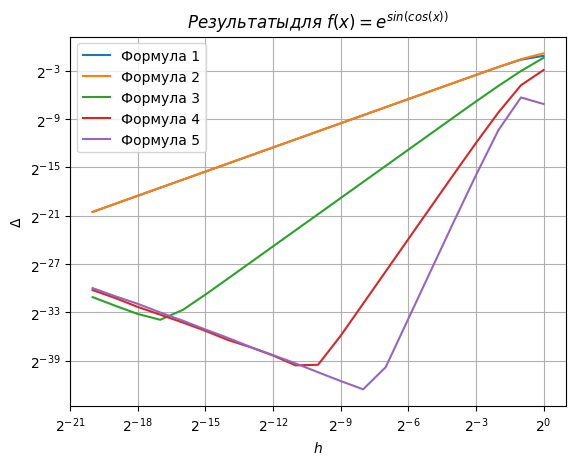

In [18]:
func = lambda X: np.exp(np.sin(np.cos(X)))
derv = lambda X: -np.sin(X) * np.cos(np.cos(X)) * func(X)

results = get_results(func, derv, bounds, step_powers, kernels)
plot_results(results, "$Результаты для~ f(x)=e^{sin(cos(x))}$")

# Функция №4

$f(x) = ln(x + 3)$

$f'(x) = \frac{1}{x + 3}$

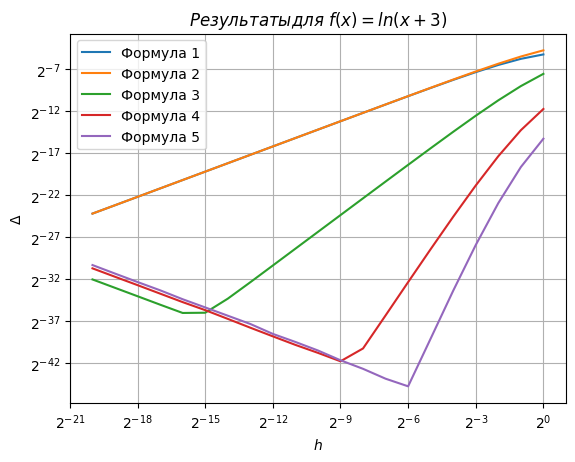

In [19]:
func = lambda X: np.log(X + 3)
derv = lambda X: 1 / (X + 3)

results = get_results(func, derv, bounds, step_powers, kernels)
plot_results(results, "$Результаты для~ f(x)=ln(x+3)$")

# Функция №5

$f(x) = \sqrt{x + 3}$

$f'(x) = \frac{1}{2\sqrt{x+3}}$

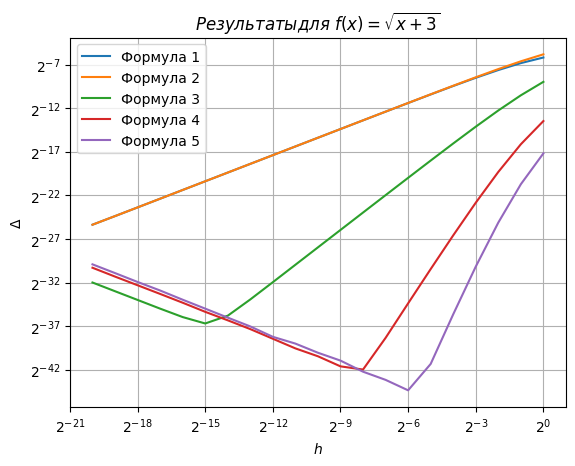

In [20]:
func = lambda X: np.sqrt(X + 3)
derv = lambda X: 1 / (2 * func(X))

results = get_results(func, derv, bounds, step_powers, kernels)
plot_results(results, "$Результаты для~ f(x)=\sqrt{x+3}$")